In [3]:
import os
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from keras.optimizers import Adam
from PIL import Image


import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
working_OS = 'Windows'

if working_OS == 'MacOS':
    os.chdir(r"/Users/jordanlee/Code/School/CSCI416/music-genre-classification")
    print("Current Working Directory:", os.getcwd())

elif working_OS == 'Windows':
    os.chdir(r"C:\Code\School\CSCI416\music_genre_classification\music-genre-classification")
    print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Code\School\CSCI416\music_genre_classification\music-genre-classification


# Data Input

In [5]:
df_raw = pd.read_csv('data/features/features_cleaned.csv')
df_aug = pd.read_csv('data/features/aug_features_cleaned.csv')

In [6]:
label_names_raw = sorted(df_raw['label'].unique())
label_names_aug = sorted(df_aug['label'].unique())

In [7]:
label_encoder =LabelEncoder()
scaler = StandardScaler()

### Raw DF

In [8]:
X_raw = df_raw.drop(columns=['label'])
y_raw = df_raw['label']

y_raw_encoded = label_encoder.fit_transform(y_raw)
X_raw_scaled = scaler.fit_transform(X_raw)
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw_scaled, y_raw_encoded, test_size=0.2, random_state=42)

### Aug DF

In [9]:
X_aug = df_aug.drop(columns=['label'])
y_aug = df_aug['label']

y_aug_encoded = label_encoder.fit_transform(y_aug)
X_aug_scaled = scaler.fit_transform(X_aug)
X_aug_train, X_aug_test, y_aug_train, y_aug_test = train_test_split(X_aug_scaled, y_aug_encoded, test_size=0.2, random_state=42)

### Dirs

In [10]:
spectrogram_raw_dir = 'data/spectrograms'
spectrogram_aug_dir = "data/aug_spectrograms"

### Staging Spectrograms

In [11]:
def load_spectrograms_and_labels(spectrogram_dir):
    spectrograms = []  # List to store spectrogram data
    labels = []        # List to store genre labels
    
    # Loop through all subdirectories (each representing a genre)
    for genre in os.listdir(spectrogram_dir):
        genre_folder = os.path.join(spectrogram_dir, genre)
        
        # Skip files, process only directories
        if os.path.isdir(genre_folder):
            for img_file in os.listdir(genre_folder):
                img_path = os.path.join(genre_folder, img_file)
                
                # Read the image using PIL (you can resize or preprocess here if needed)
                img = Image.open(img_path).convert('L')  # Convert to grayscale ('L')
                img = img.resize((128, 128))  # Resize to 128x128 (adjust as needed)
                
                # Convert image to numpy array
                img_array = np.array(img)
                
                # Append the image and its genre label
                spectrograms.append(img_array)
                labels.append(genre)  # The genre is the label for classification
    
    # Convert lists to numpy arrays
    X_spectrograms = np.array(spectrograms)
    y_labels = np.array(labels)
    
    return X_spectrograms, y_labels

In [12]:
# Load spectrograms and labels
X_raw_spectrograms, y_raw_spectrogram_labels = load_spectrograms_and_labels(spectrogram_raw_dir)
X_aug_spectrograms, y_aug_spectrogram_labels = load_spectrograms_and_labels(spectrogram_aug_dir)

# Normalize pixel values (between 0 and 1)
X_raw_spectrograms = X_raw_spectrograms.astype('float32') / 255.0
X_aug_spectrograms = X_aug_spectrograms.astype('float32') / 255.0

# Reshape to add channel dimension (since images are grayscale, the channel is 1)
X_raw_spectrograms = X_raw_spectrograms.reshape(-1, 128, 128, 1)
X_aug_spectrograms = X_aug_spectrograms.reshape(-1, 128, 128, 1)

# Encode labels (genres) as numeric values
y_raw_spectrogram_labels_encoded = label_encoder.fit_transform(y_raw_spectrogram_labels)
y_aug_spectrogram_labels_encoded = label_encoder.fit_transform(y_aug_spectrogram_labels)

# Optional: one-hot encode the labels if needed (for multi-class classification)
y_raw_labels_one_hot = np.eye(len(label_encoder.classes_))[y_raw_spectrogram_labels_encoded]
y_aug_labels_one_hot = np.eye(len(label_encoder.classes_))[y_aug_spectrogram_labels_encoded]

X_raw_train_CNN, X_raw_test_CNN, y_raw_train_CNN, y_raw_test_CNN = train_test_split(
    X_raw_spectrograms, y_raw_labels_one_hot, test_size=0.2, random_state=42
)

X_aug_train_CNN, X_aug_test_CNN, y_aug_train_CNN, y_aug_test_CNN = train_test_split(
    X_aug_spectrograms, y_aug_labels_one_hot, test_size=0.2, random_state=42
)

 ### Defining CNNs

##### Might not need this? 

In [142]:
# Initialize the ImageDataGenerator for augmentation
datagen_raw = ImageDataGenerator(
    rotation_range=30,       # Random rotations
    width_shift_range=0.2,   # Random width shifts
    height_shift_range=0.2,  # Random height shifts
    shear_range=0.2,         # Random shearing
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest'      # Fill missing pixels after transformations
)

datagen_aug = ImageDataGenerator(
    rotation_range=30,       # Random rotations
    width_shift_range=0.2,   # Random width shifts
    height_shift_range=0.2,  # Random height shifts
    shear_range=0.2,         # Random shearing
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest'      # Fill missing pixels after transformations
)

# Fit the generator on your training data
datagen_raw.fit(X_raw_train_CNN)

datagen_aug.fit(X_aug_train_CNN)

## Model Training

### Random Forest Models

#### Optimization

In [32]:
def optimize_rf_hyperparameters(X, y):
    # Create a pipeline that includes scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=42))
    ])
    
    # Parameter grid for Random Forest
    param_dist = {
        'rf__n_estimators': [50, 100, 200],
        'rf__max_depth': [None, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4]
    }
    
    # Randomized search with cross-validation
    random_search = RandomizedSearchCV(
        pipeline, 
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        scoring='accuracy',
        random_state=42
    )
    
    # Fit on the original X and y (scaling happens inside the pipeline)
    random_search.fit(X, y)
    
    print("Best parameters:", random_search.best_params_)
    print("Best cross-validated score:", random_search.best_score_)
    
    return random_search.best_estimator_


In [28]:
optimize_rf_hyperparameters(X_raw_scaled, y_raw_encoded)

Best parameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_depth': None}
Best cross-validated score: 0.6235728643216081


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(min_samples_leaf=2, random_state=42))])

In [29]:
optimize_rf_hyperparameters(X_aug_scaled, y_aug_encoded)

Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 30}
Best cross-validated score: 0.5919304396215915


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=30, n_estimators=200,
                                        random_state=42))])

#### Models

In [14]:
rf_raw_model = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf= 2, max_depth= None, random_state=42)
rf_raw_model.fit(X_raw_train, y_raw_train)

RandomForestClassifier(min_samples_leaf=2, random_state=42)

In [15]:
rf_aug_model = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf= 1, max_depth= 30, random_state=42)
rf_aug_model.fit(X_aug_train, y_aug_train)

RandomForestClassifier(max_depth=30, n_estimators=200, random_state=42)

### Support Vector Machines

#### Optimizing

In [50]:
def optimize_svm_hyperparameters(X, y):
    # Create a pipeline that includes scaling and SVM
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, random_state=42))
    ])
    
    # Comprehensive parameter grid for SVM
    param_dist = {
        'svm__C': [0.1, 1, 10, 100],  # Regularization parameter
        'svm__kernel': ['rbf', 'linear', 'poly'],  # Kernel types
        'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
        'svm__class_weight': [None, 'balanced'],
        'svm__degree': [2, 3, 4]  # For polynomial kernel
    }
    
    # Randomized search with cross-validation
    random_search = RandomizedSearchCV(
        svm_pipeline, 
        param_distributions=param_dist,
        n_iter=20,  # Number of parameter settings to sample
        cv=5,  # 5-fold cross-validation
        scoring='accuracy',
        random_state=42,
        verbose=2  # Show progress
    )
    
    # Fit on the data
    random_search.fit(X, y)
    
    # Print results
    print("Best SVM parameters:", random_search.best_params_)
    print("Best cross-validated score:", random_search.best_score_)
    
    return random_search.best_estimator_

In [35]:
best_raw_svm = optimize_svm_hyperparameters(X_raw_scaled, y_raw_encoded)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=rbf; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=rbf; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=rbf; total time=   0.1s
[CV] END svm__C=0.1, svm__

In [36]:
best_aug_svm = optimize_svm_hyperparameters(X_aug_scaled, y_aug_encoded)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.8s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.8s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.8s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.8s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.8s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=0.1, svm__

#### Models

In [16]:
svm_raw_model = SVC(kernel='rbf', gamma= 0.01, degree=4, class_weight='balanced', C=100, probability=True, random_state=42)
svm_raw_model.fit(X_raw_train, y_raw_train)

SVC(C=100, class_weight='balanced', degree=4, gamma=0.01, probability=True,
    random_state=42)

In [17]:
svm_aug_model = SVC(kernel='rbf', gamma= 0.01, degree=4, class_weight='balanced', C=100, probability=True, random_state=42)
svm_aug_model.fit(X_aug_train, y_aug_train)

SVC(C=100, class_weight='balanced', degree=4, gamma=0.01, probability=True,
    random_state=42)

### Convolutional Neural Network

In [46]:
# Must generate from other notebooks (too big for GitHub)
small_raw_CNN_model = joblib.load('models/small_raw_CNN_model.joblib')
large_raw_CNN_model = joblib.load('models/large_raw_CNN_model.joblib')
small_aug_CNN_model = joblib.load('models/small_aug_CNN_model.joblib')
large_aug_CNN_model = joblib.load('models/large_aug_CNN_model.joblib')

In [47]:
small_raw_CNN_model.fit(
    [X_raw_train, X_raw_train_CNN], y_raw_train_CNN, 
    epochs=10, 
    batch_size=32, 
    validation_data=([X_raw_test, X_raw_test_CNN], y_raw_test_CNN)
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.6800 - val_loss: 1.3363
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.6800 - val_loss: 1.3708
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.6850 - val_loss: 1.3867
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.6750 - val_loss: 1.3963
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.6900 - val_loss: 1.4123
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.6750 - val_loss: 1.4394
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.6850 - val_loss: 1.4566
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.6850 - v

In [48]:
large_raw_CNN_model.fit(
    [X_raw_train, X_raw_train_CNN], y_raw_train_CNN, 
    epochs=10, 
    batch_size=32, 
    validation_data=([X_raw_test, X_raw_test_CNN], y_raw_test_CNN)
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 385ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.1350 - val_loss: 4.3439
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.4100 - val_loss: 1.8956
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.2250 - val_loss: 2.7006
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.2100 - val_loss: 3.5862
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step - accuracy: 0.9999 - loss: 0.0069 - val_accuracy: 0.3200 - val_loss: 2.5498
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - accuracy: 0.9985 - loss: 0.0092 - val_accuracy: 0.2700 - val_loss: 2.9844
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.3550 - val_loss: 2.8416
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 

In [49]:
small_aug_CNN_model.fit(
    [X_aug_train, X_aug_train_CNN], y_aug_train_CNN, 
    epochs=10, 
    batch_size=32, 
    validation_data=([X_raw_test, X_raw_test_CNN], y_raw_test_CNN)
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9653 - loss: 0.1570 - val_accuracy: 0.1250 - val_loss: 20.0026
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9736 - loss: 0.1218 - val_accuracy: 0.1050 - val_loss: 19.8286
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9944 - loss: 0.0572 - val_accuracy: 0.1200 - val_loss: 19.3773
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9966 - loss: 0.0405 - val_accuracy: 0.1300 - val_loss: 17.7409
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9977 - loss: 0.0232 - val_accuracy: 0.1150 - val_loss: 20.4822
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.1100 - val_loss: 24.1692
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.1100 - val_loss: 25.4754
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.1

In [50]:
large_aug_CNN_model.fit(
    [X_aug_train, X_aug_train_CNN], y_aug_train_CNN, 
    epochs=10, 
    batch_size=32, 
    validation_data=([X_raw_test, X_raw_test_CNN], y_raw_test_CNN)
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 340ms/step - accuracy: 0.3249 - loss: 2.2864 - val_accuracy: 0.0600 - val_loss: 12.1574
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 334ms/step - accuracy: 0.6221 - loss: 1.1529 - val_accuracy: 0.2100 - val_loss: 4.5737
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 336ms/step - accuracy: 0.7388 - loss: 0.8076 - val_accuracy: 0.1600 - val_loss: 4.7056
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 335ms/step - accuracy: 0.8421 - loss: 0.4988 - val_accuracy: 0.2150 - val_loss: 3.3377
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 343ms/step - accuracy: 0.9174 - loss: 0.2739 - val_accuracy: 0.1050 - val_loss: 6.3589
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 345ms/step - accuracy: 0.9340 - loss: 0.2092 - val_accuracy: 0.1350 - val_loss: 14.1401
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - accuracy: 0.9468 - loss: 0.1701 - val_accuracy: 0.1100 - val_loss: 12.8561
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 336ms/step - accuracy: 0.9823 - loss: 0.0877 - val_a

In [52]:
joblib.dump(small_raw_CNN_model,'models/small_raw_CNN_model.joblib')
joblib.dump(large_raw_CNN_model, 'models/large_raw_CNN_model.joblib')
joblib.dump(small_aug_CNN_model, 'models/small_aug_CNN_model.joblib')
joblib.dump(large_aug_CNN_model, 'models/large_aug_CNN_model.joblib')

['models/large_aug_CNN_model.joblib']

### Accuracy Testing

##### RF

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.75      1.00      0.86        12
           2       0.78      0.75      0.77        24
           3       0.95      0.82      0.88        22
           4       0.71      0.80      0.75        15
           5       0.96      0.93      0.94        27
           6       0.86      1.00      0.92        18
           7       0.81      0.89      0.85        19
           8       0.76      0.73      0.74        22
           9       0.59      0.50      0.54        20

    accuracy                           0.81       200
   macro avg       0.81      0.82      0.81       200
weighted avg       0.82      0.81      0.81       200

Accuracy: 0.815


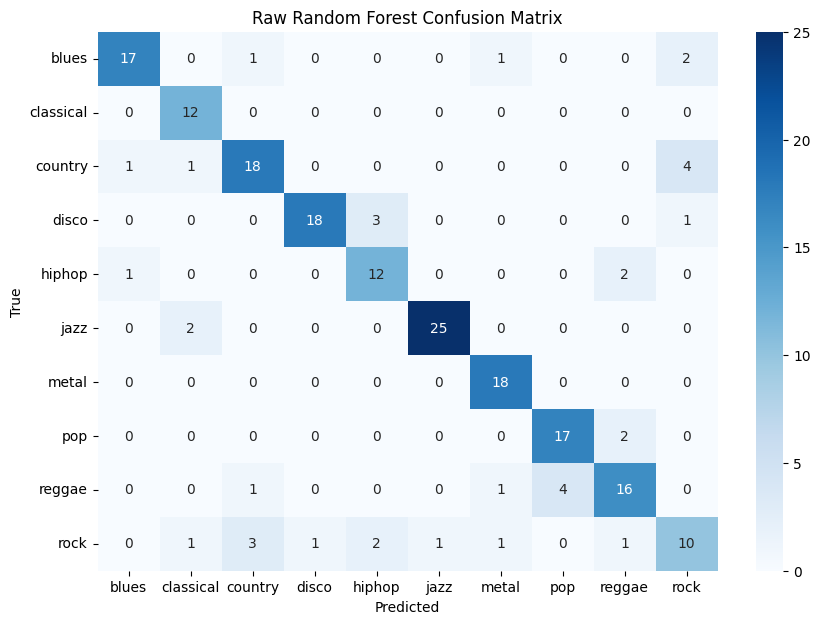

In [35]:
y_pred_rf_raw = rf_raw_model.predict(X_raw_test)
print(classification_report(y_raw_test, y_pred_rf_raw))
print("Accuracy:", accuracy_score(y_raw_test, y_pred_rf_raw))

cm_rf_raw = confusion_matrix(y_raw_test, y_pred_rf_raw)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_raw, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_raw, yticklabels=label_names_raw)
plt.title('Raw Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.67      1.00      0.80        12
           2       0.91      0.83      0.87        24
           3       0.94      0.73      0.82        22
           4       0.81      0.87      0.84        15
           5       0.96      0.85      0.90        27
           6       0.78      1.00      0.88        18
           7       0.86      1.00      0.93        19
           8       0.91      0.91      0.91        22
           9       0.76      0.65      0.70        20

    accuracy                           0.86       200
   macro avg       0.86      0.87      0.85       200
weighted avg       0.87      0.86      0.86       200

Accuracy: 0.86


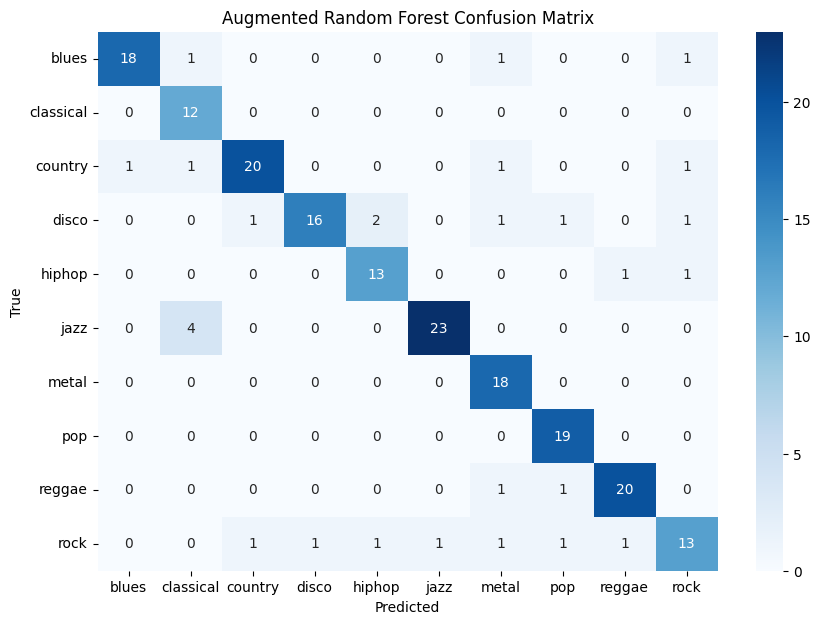

In [36]:
y_pred_rf_aug = rf_aug_model.predict(X_raw_test)
print(classification_report(y_raw_test, y_pred_rf_aug))
print("Accuracy:", accuracy_score(y_raw_test, y_pred_rf_aug))

cm_rf_aug = confusion_matrix(y_raw_test, y_pred_rf_aug)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_aug, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_aug, yticklabels=label_names_aug)
plt.title('Augmented Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##### SVM

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        21
           1       0.85      0.92      0.88        12
           2       0.70      0.79      0.75        24
           3       0.65      0.68      0.67        22
           4       0.71      0.80      0.75        15
           5       0.88      0.85      0.87        27
           6       0.88      0.83      0.86        18
           7       0.89      0.84      0.86        19
           8       0.68      0.59      0.63        22
           9       0.50      0.45      0.47        20

    accuracy                           0.75       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.75      0.75      0.75       200

Accuracy: 0.75


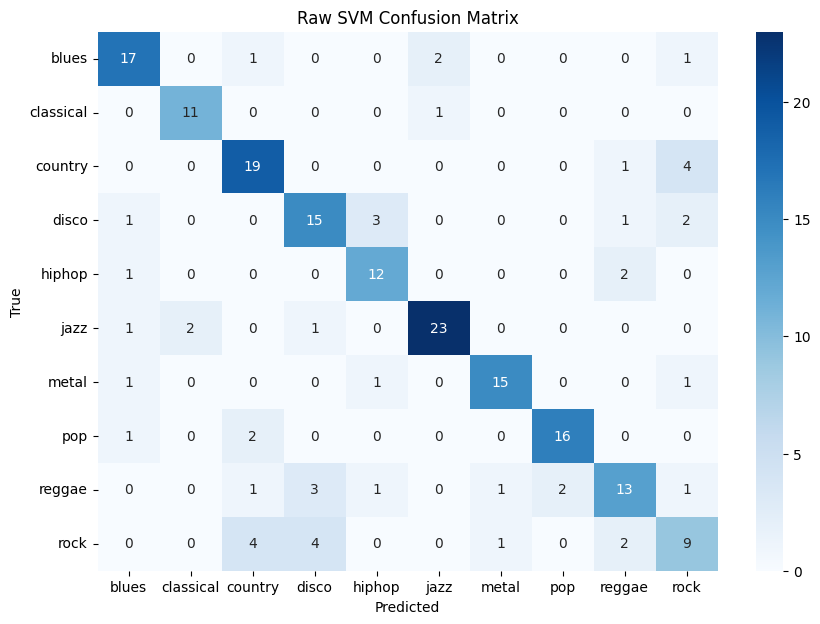

In [37]:
y_pred_svm_raw = svm_raw_model.predict(X_raw_test)
print(classification_report(y_raw_test, y_pred_svm_raw))
print("Accuracy:", accuracy_score(y_raw_test, y_pred_svm_raw))

cm_svm_raw = confusion_matrix(y_raw_test, y_pred_svm_raw)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_raw, yticklabels=label_names_raw)
plt.title('Raw SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.92      0.92      0.92        12
           2       0.96      1.00      0.98        24
           3       1.00      0.95      0.98        22
           4       1.00      0.93      0.97        15
           5       0.96      1.00      0.98        27
           6       0.86      1.00      0.92        18
           7       0.90      0.95      0.92        19
           8       0.95      0.95      0.95        22
           9       1.00      0.80      0.89        20

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200

Accuracy: 0.95


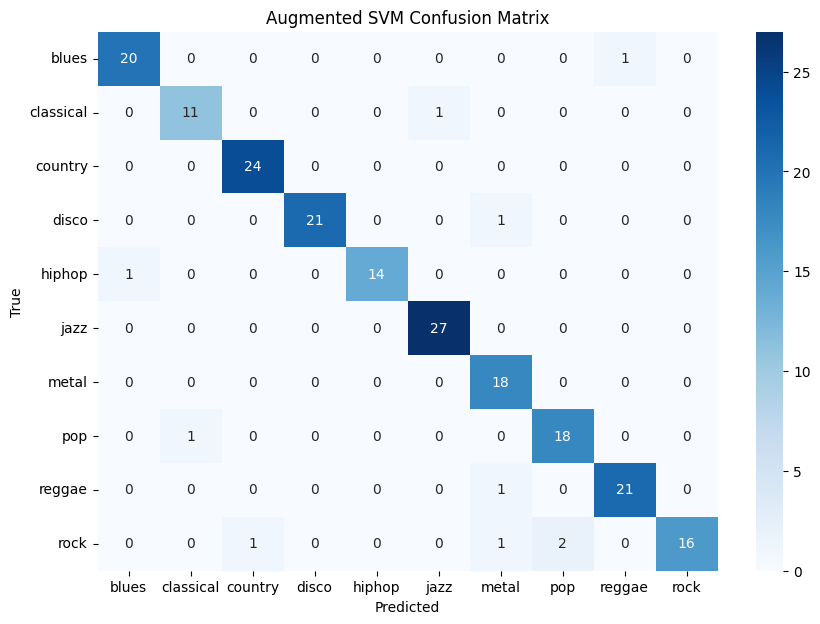

In [38]:
y_pred_svm_aug = svm_aug_model.predict(X_raw_test)
print(classification_report(y_raw_test, y_pred_svm_aug))
print("Accuracy:", accuracy_score(y_raw_test, y_pred_svm_aug))

cm_svm_raw = confusion_matrix(y_raw_test, y_pred_svm_aug)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_aug, yticklabels=label_names_aug)
plt.title('Augmented SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##### CNN

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6698 - loss: 1.7225
Test loss: 1.4927036762237549
Test accuracy: 0.6800000071525574
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


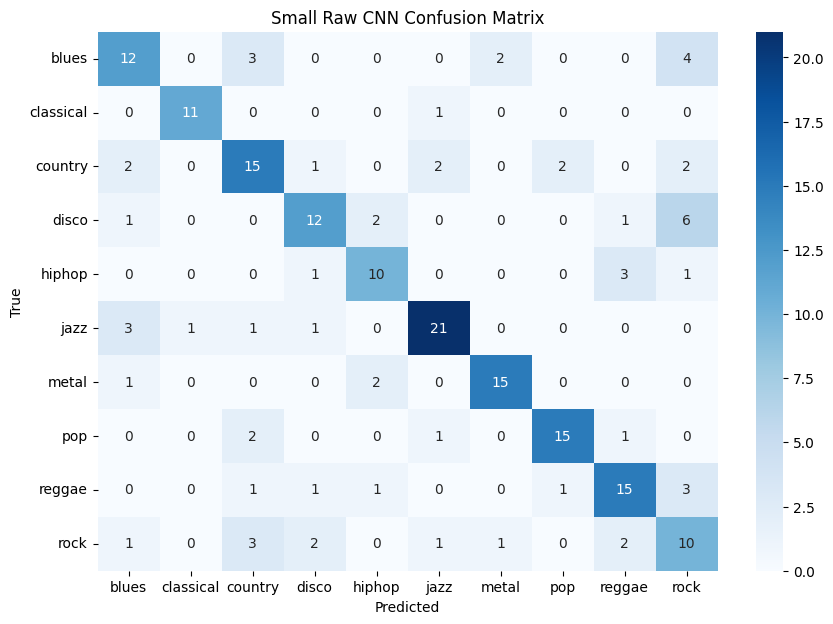

In [53]:
test_small_raw_loss, test_small_raw_accuracy = small_raw_CNN_model.evaluate([X_raw_test, X_raw_test_CNN], y_raw_test_CNN)

# Print the results
print(f"Test loss: {test_small_raw_loss}")
print(f"Test accuracy: {test_small_raw_accuracy}")

# Get predictions from the model (probabilities for each class)
y_pred_probs_small_CNN_raw = small_raw_CNN_model.predict([X_raw_test, X_raw_test_CNN])

# Convert probabilities to class labels
y_pred_small_CNN_raw = np.argmax(y_pred_probs_small_CNN_raw, axis=1)

# Compute confusion matrix
cm_small_CNN_raw = confusion_matrix(y_raw_test, y_pred_small_CNN_raw)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_small_CNN_raw, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_raw, yticklabels=label_names_raw)
plt.title('Small Raw CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4732 - loss: 1.9114
Test loss: 1.8386880159378052
Test accuracy: 0.48500001430511475
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


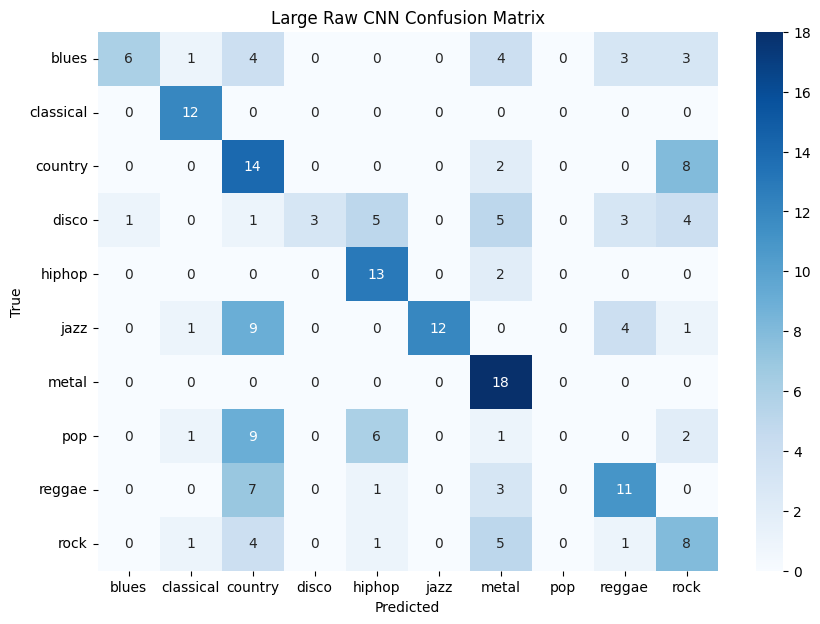

In [54]:
test_large_raw_loss, test_large_raw_accuracy = large_raw_CNN_model.evaluate([X_raw_test, X_raw_test_CNN], y_raw_test_CNN)

# Print the results
print(f"Test loss: {test_large_raw_loss}")
print(f"Test accuracy: {test_large_raw_accuracy}")

# Get predictions from the model (probabilities for each class)
y_pred_probs_large_CNN_raw = large_raw_CNN_model.predict([X_raw_test, X_raw_test_CNN])

# Convert probabilities to class labels
y_pred_large_CNN_raw = np.argmax(y_pred_probs_large_CNN_raw, axis=1)

# Compute confusion matrix
cm_large_CNN_raw = confusion_matrix(y_raw_test, y_pred_large_CNN_raw)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_large_CNN_raw, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_raw, yticklabels=label_names_raw)
plt.title('Large Raw CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1069 - loss: 28.5656
Test loss: 27.796472549438477
Test accuracy: 0.10999999940395355
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


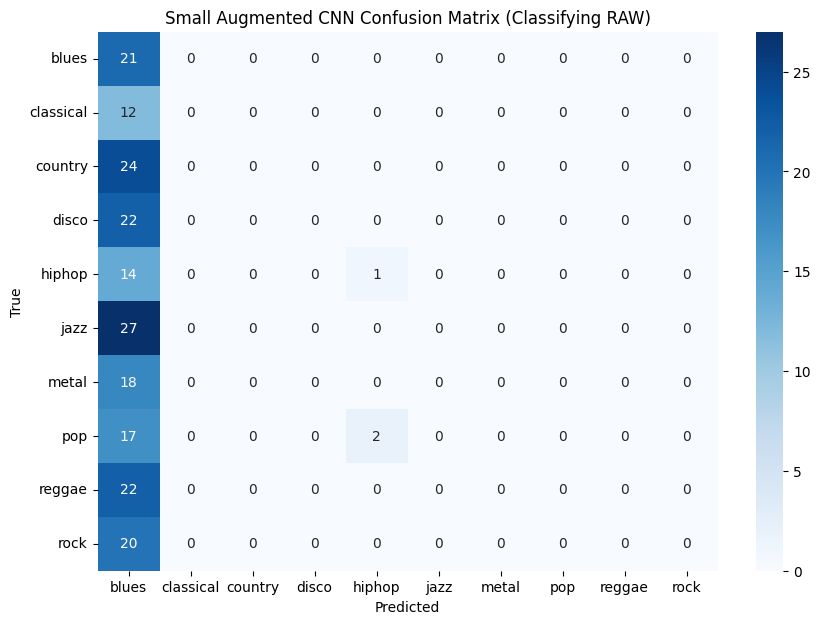

In [70]:
test_small_aug_loss, test_small_aug_accuracy = small_aug_CNN_model.evaluate([X_raw_test, X_raw_test_CNN], y_raw_test_CNN)

# Print the results
print(f"Test loss: {test_small_aug_loss}")
print(f"Test accuracy: {test_small_aug_accuracy}")

# Get predictions from the model (probabilities for each class)
y_pred_probs_small_CNN_aug = small_aug_CNN_model.predict([X_raw_test, X_raw_test_CNN])

# Convert probabilities to class labels
y_pred_small_CNN_aug = np.argmax(y_pred_probs_small_CNN_aug, axis=1)

# Compute confusion matrix
cm_small_CNN_aug = confusion_matrix(y_raw_test, y_pred_small_CNN_aug)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_small_CNN_aug, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_aug, yticklabels=label_names_aug)
plt.title('Small Augmented CNN Confusion Matrix (Classifying RAW)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1111 - loss: 13.3731
Test loss: 13.375044822692871
Test accuracy: 0.11500000208616257
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


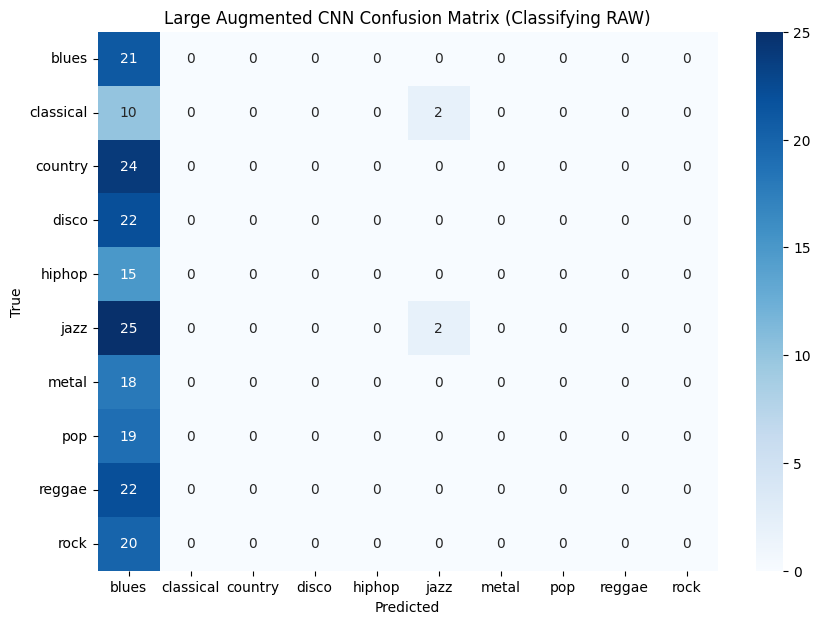

In [72]:
test_large_aug_loss, test_large_aug_accuracy = large_aug_CNN_model.evaluate([X_raw_test, X_raw_test_CNN], y_raw_test_CNN)

# Print the results
print(f"Test loss: {test_large_aug_loss}")
print(f"Test accuracy: {test_large_aug_accuracy}")

# Get predictions from the model (probabilities for each class)
y_pred_probs_large_CNN_aug = large_aug_CNN_model.predict([X_raw_test, X_raw_test_CNN])

# Convert probabilities to class labels
y_pred_large_CNN_aug = np.argmax(y_pred_probs_large_CNN_aug, axis=1)

# Compute confusion matrix
cm_large_CNN_aug = confusion_matrix(y_raw_test, y_pred_large_CNN_aug)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_large_CNN_aug, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_aug, yticklabels=label_names_aug)
plt.title('Large Augmented CNN Confusion Matrix (Classifying RAW)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8001 - loss: 0.9190
Test loss: 0.8465023636817932
Test accuracy: 0.79666668176651
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


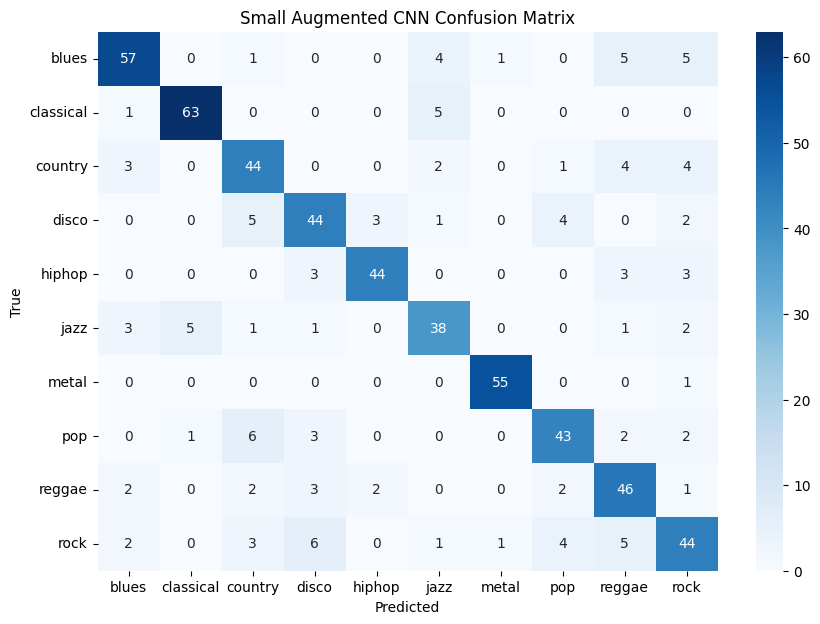

In [78]:
test_small_aug_loss, test_small_aug_accuracy = small_aug_CNN_model.evaluate([X_aug_test, X_aug_test_CNN], y_aug_test_CNN)

# Print the results
print(f"Test loss: {test_small_aug_loss}")
print(f"Test accuracy: {test_small_aug_accuracy}")

# Get predictions from the model (probabilities for each class)
y_pred_probs_small_CNN_aug = small_aug_CNN_model.predict([X_aug_test, X_aug_test_CNN])

# Convert probabilities to class labels
y_pred_small_CNN_aug = np.argmax(y_pred_probs_small_CNN_aug, axis=1)

# Compute confusion matrix
cm_small_CNN_aug = confusion_matrix(y_aug_test, y_pred_small_CNN_aug)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_small_CNN_aug, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_aug, yticklabels=label_names_aug)
plt.title('Small Augmented CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7966 - loss: 0.7696
Test loss: 0.635928213596344
Test accuracy: 0.8216666579246521
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


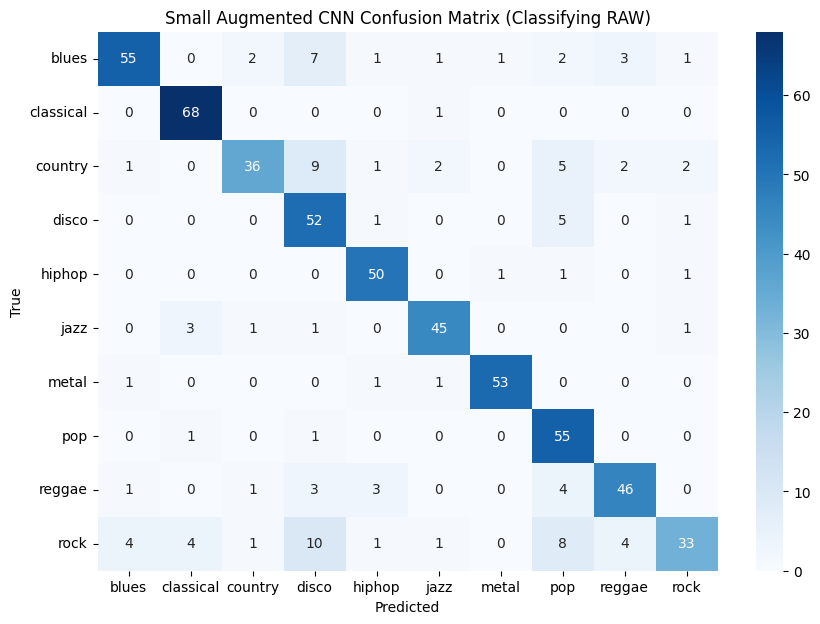

In [79]:
test_large_aug_loss, test_large_aug_accuracy = large_aug_CNN_model.evaluate([X_aug_test, X_aug_test_CNN], y_aug_test_CNN)

# Print the results
print(f"Test loss: {test_large_aug_loss}")
print(f"Test accuracy: {test_large_aug_accuracy}")

# Get predictions from the model (probabilities for each class)
y_pred_probs_large_CNN_aug = large_aug_CNN_model.predict([X_aug_test, X_aug_test_CNN])

# Convert probabilities to class labels
y_pred_large_CNN_aug = np.argmax(y_pred_probs_large_CNN_aug, axis=1)

# Compute confusion matrix
cm_large_CNN_aug = confusion_matrix(y_aug_test, y_pred_large_CNN_aug)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_large_CNN_aug, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_aug, yticklabels=label_names_aug)
plt.title('Small Augmented CNN Confusion Matrix (Classifying RAW)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

C:\Users\jplee\AppData\Local\Temp\ipykernel_54228\2598145113.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Set2')  # Choose a color palette (e.g., 'Set2', 'viridis', 'plasma')


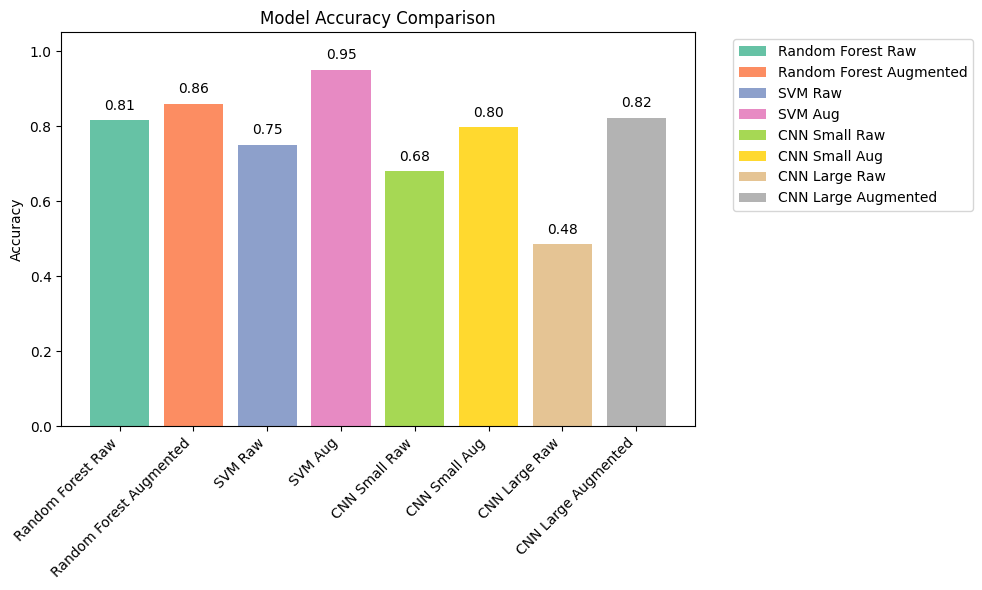

In [85]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Calculate accuracy for each model
accuracy_rf_raw = accuracy_score(y_raw_test, y_pred_rf_raw)
accuracy_rf_aug = accuracy_score(y_raw_test, y_pred_rf_aug)
accuracy_svm_raw = accuracy_score(y_raw_test, y_pred_svm_raw)
accuracy_svm_aug = accuracy_score(y_raw_test, y_pred_svm_aug)

# For the CNN model
accuracy_cnn_small_raw_loss = accuracy_score(y_raw_test, y_pred_small_CNN_raw)
accuracy_cnn_large_raw_loss = accuracy_score(y_raw_test, y_pred_large_CNN_raw)
accuracy_cnn_small_aug_loss = accuracy_score(y_aug_test, y_pred_small_CNN_aug)
accuracy_cnn_large_aug_loss = accuracy_score(y_aug_test, y_pred_large_CNN_aug)

# Prepare model names and their corresponding accuracies
models = ['Random Forest Raw', 'Random Forest Augmented', 'SVM Raw', 'SVM Aug',
          'CNN Small Raw', 'CNN Small Aug', 'CNN Large Raw', 'CNN Large Augmented']
accuracies = [accuracy_rf_raw, accuracy_rf_aug, accuracy_svm_raw, accuracy_svm_aug,
              accuracy_cnn_small_raw_loss, accuracy_cnn_small_aug_loss,
              accuracy_cnn_large_raw_loss, accuracy_cnn_large_aug_loss]

# Use a colormap to generate colors dynamically
cmap = get_cmap('Set2')  # Choose a color palette (e.g., 'Set2', 'viridis', 'plasma')
colors = [cmap(i / len(models)) for i in range(len(models))]

# Create a bar plot for comparison
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, accuracies, color=colors)
ax.set_title('Model Accuracy Comparison')
ax.set_ylabel('Accuracy')

# Adjust y-axis limits to ensure there's space above the highest bar
ax.set_ylim(0, 1.05)  # Increase the upper limit slightly to prevent hitting the top

# Rotate x-axis labels to prevent overcrowding
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add numerical values above the bars for better clarity
for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom', fontsize=10)

# Create a legend with model names
ax.legend(bars, models, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
